In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as explot

import seaborn as sns
sns.set()
import plotly.express as explot
import itertools, copy
import warnings

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import accuracy_score
from scipy.stats import boxcox, probplot, norm
from scipy.stats import mode, multivariate_normal

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")

In [51]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

**Seeds Dataset**
1. area A,
2. perimeter P,
3. compactness $C = \frac{4*\pi*A}{P^2}$,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.

In [2]:
#import dataset
# df = pd.read_csv('/content/drive/MyDrive/118B/seeds.csv', header= None)
df = pd.read_csv('seeds.csv', header= None)


#name columns
df.columns = ['area','perimeter','compactness','length','width','asymmetry','groove','group']

#saving group id variable for later
groups = df['group']
df.drop('group', axis = 1, inplace = True)

df.head()

area  perimeter  compactness  length  width  asymmetry  groove
0  15.26      14.84       0.8710   5.763  3.312      2.221   5.220
1  14.88      14.57       0.8811   5.554  3.333      1.018   4.956
2  14.29      14.09       0.9050   5.291  3.337      2.699   4.825
3  13.84      13.94       0.8955   5.324  3.379      2.259   4.805
4  16.14      14.99       0.9034   5.658  3.562      1.355   5.175

**Clean Data**

In [82]:
#check data types
df.dtypes

area           float64
perimeter      float64
compactness    float64
length         float64
width          float64
asymmetry      float64
groove         float64
dtype: object

In [83]:
#drop nan or blanks if any
df.isnull().values.any()

False

In [3]:
#mean, sd, n, 
mean = np.mean(df,axis = 0)
sd = np.std(df,axis = 0)

print('n =',df.shape[0])
df.describe().T.drop(['count'],axis = 1) #not sure which ones to drop

n = 210


mean       std      min       25%       50%        75%  \
area         14.847524  2.909699  10.5900  12.27000  14.35500  17.305000   
perimeter    14.559286  1.305959  12.4100  13.45000  14.32000  15.715000   
compactness   0.870999  0.023629   0.8081   0.85690   0.87345   0.887775   
length        5.628533  0.443063   4.8990   5.26225   5.52350   5.979750   
width         3.258605  0.377714   2.6300   2.94400   3.23700   3.561750   
asymmetry     3.700201  1.503557   0.7651   2.56150   3.59900   4.768750   
groove        5.408071  0.491480   4.5190   5.04500   5.22300   5.877000   

                 max  
area         21.1800  
perimeter    17.2500  
compactness   0.9183  
length        6.6750  
width         4.0330  
asymmetry     8.4560  
groove        6.5500

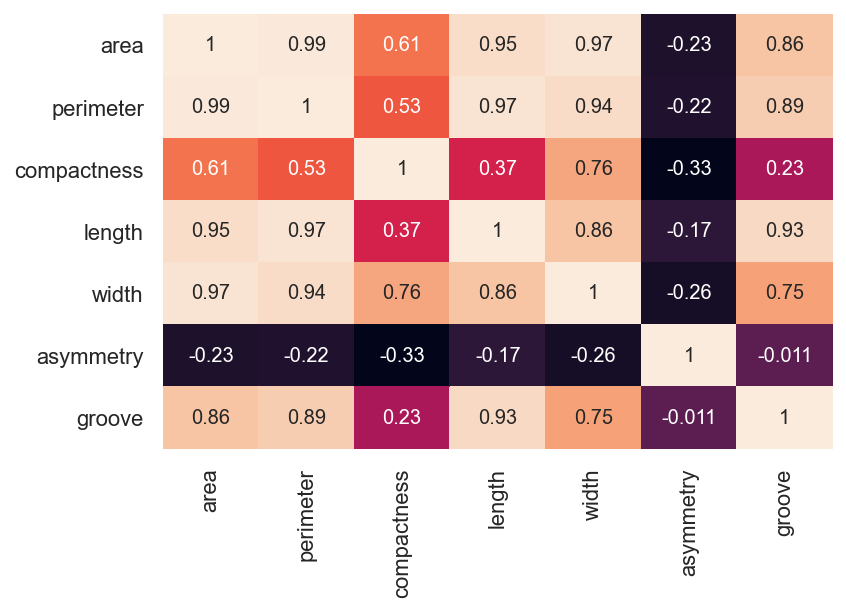

In [4]:
sns.heatmap(df.corr(), annot=True, cbar=False);

In [5]:
# drop some of columns that are highly dependant 
# (like 'area' and 'perimeter')
df = df.drop(columns=['perimeter'])

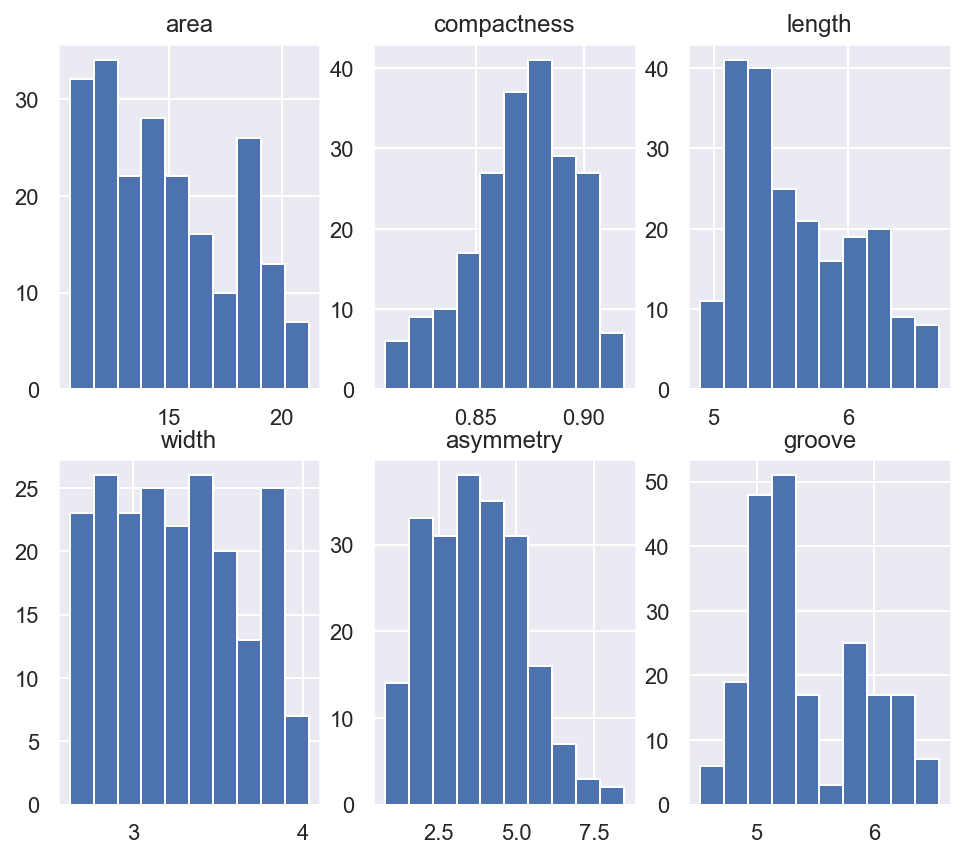

In [6]:
plt.rcParams['figure.figsize'] = [8,7] #sets figure size
fig, axs = plt.subplots(2, 3)
index = 0
#loop through number of subplots
for i in range(2):
  for j in range(3):
    axs[i,j].hist(df.iloc[:,index])
    axs[i,j].set_title(df.columns[index])
    index += 1

In [7]:
# transform data and apply StandardScaler

df_box = PowerTransformer(method='box-cox').fit_transform(df)
df_std = StandardScaler().fit_transform(df_box)
df_norm = pd.DataFrame(df_std, columns=df.columns)

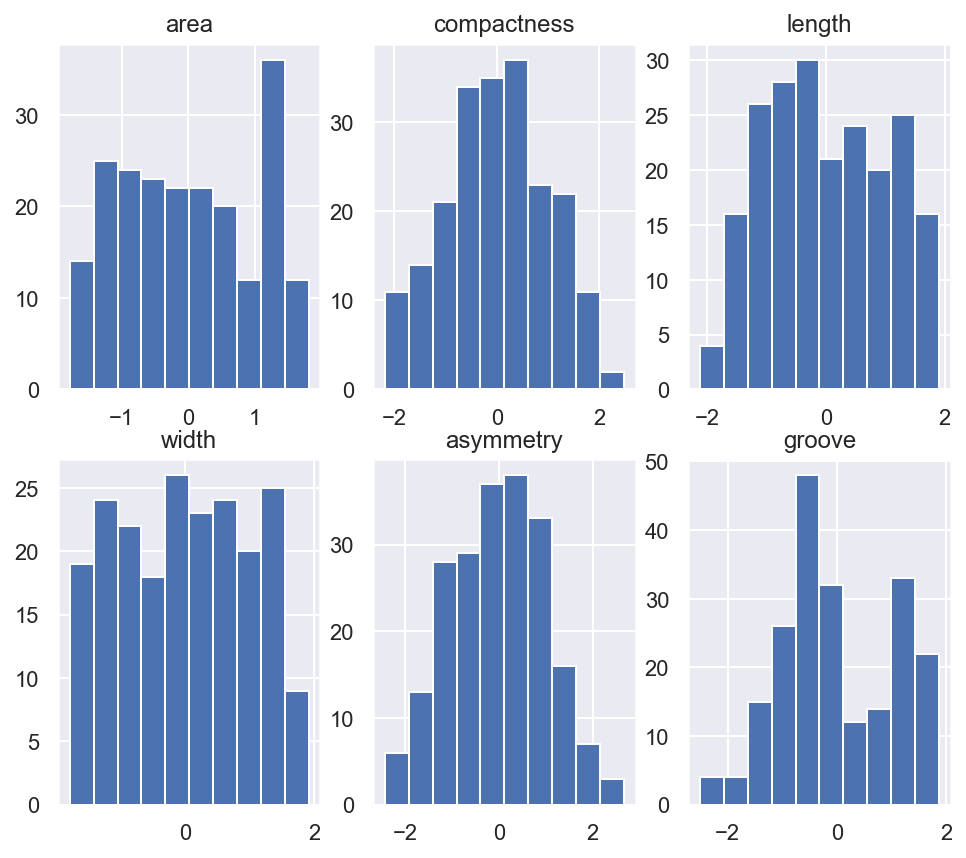

In [9]:
plt.rcParams['figure.figsize'] = [8,7] #sets figure size
fig, axs = plt.subplots(2, 3)
index = 0
#loop through number of subplots
for i in range(2):
  for j in range(3):
    axs[i,j].hist(df_norm.iloc[:,index])
    axs[i,j].set_title(df_norm.columns[index])
    index += 1


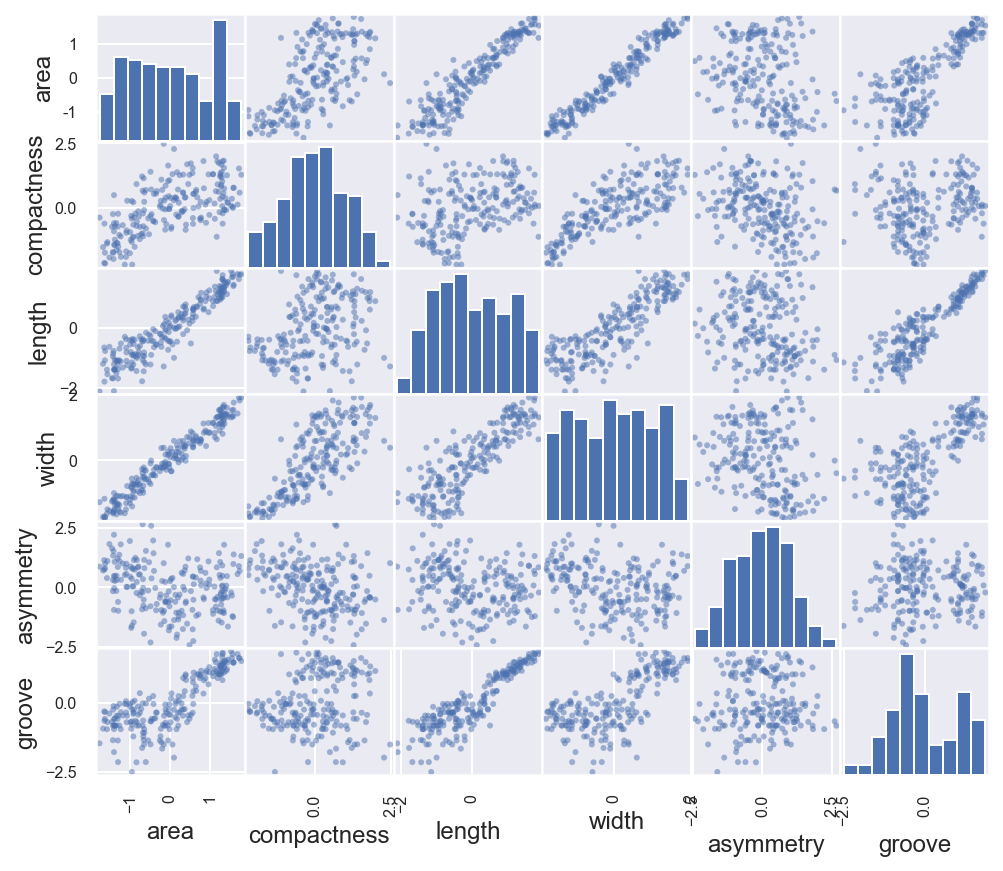

In [10]:
#scatter matrix
pd.plotting.scatter_matrix(df_norm)
plt.show()

## PCA

In [11]:
def PCA(X, num_components):

  #Calculate the matrix of mean subtracted data points
  Z = X - np.mean(X, axis = 0)

  #Calculate the covariance matrix of the mean subtracted data points
  cov = np.cov(Z, rowvar = False)

  #Find the eigenvalues and eigenvectors of the covariance matrix
  eigen_values, eigen_vectors = np.linalg.eigh(cov)

  #Sort the eigenvalues and eigenvectors in descending order
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalues = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:, sorted_index]

  #Create a subset from the ordered Eigenvalue matrix using the first n_components eigenvectors
  new_eigenvectors = sorted_eigenvectors[:, 0 : num_components]

  #Transform the data from higher dimension to lower dimension
  X_reduced = np.dot(new_eigenvectors.transpose(), Z.transpose()).transpose()

  return X_reduced, sorted_eigenvalues

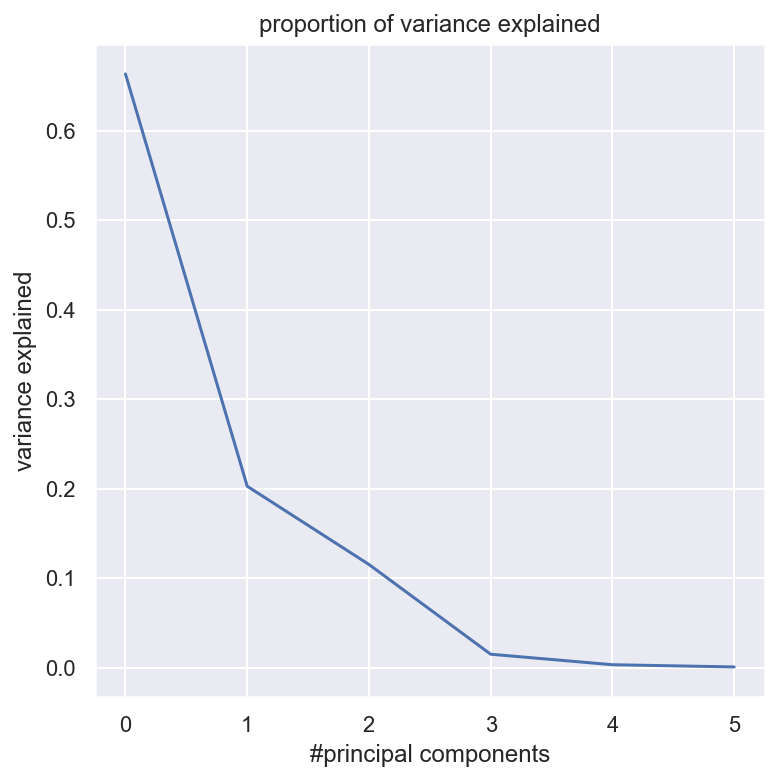

In [13]:
# Find percentage of variance explained by principal component
vals = PCA(df_norm,7)[1] #7 doesnt matter here since we only want the eigenvalues
var_explained = vals/np.sum(vals) #standardize eigenvalues

#plot
plt.rcParams['figure.figsize'] = [6,6]
plt.plot(var_explained)
plt.title('proportion of variance explained')
plt.xlabel('#principal components')
plt.ylabel('variance explained')
plt.show()

#looks at the elbow is at 2 principal components

In [15]:
# create dataframes with 2 and 3 principle components 
PC2 = PCA(df_norm, 2)[0]
df_2comp = pd.DataFrame(PC2, columns = ['PC1', 'PC2'])

PC3 = PCA(df_norm, 3)[0]
df_3comp = pd.DataFrame(PC3, columns = ['PC1', 'PC2', 'PC3'])

Will probabily run kmeans and mog with 2 or 3 principal components

In [16]:
class KMeansClusters:
    
    def __init__(self, X, k, max_iters=100):
        self.X = X
        self.k = k
        self.max_iters = max_iters
        
        self.dim = X.shape[1]
        self.N = X.shape[0]
        
        centroid_indices = np.random.RandomState(2).permutation(X.shape[0])[:k]
        self.centroids = X[centroid_indices]
        
        self.clusters = self.get_clusters(self.X, self.centroids)
    
    def get_clusters(self, X, centroids):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)
    
    def plot_data_2d(self, labels):
        sns.scatterplot(self.X[:,0], self.X[:,1], hue=labels, palette="deep")
        plt.title('Using comp1, comp2')
        plt.show()

    def plot_data_3d(self, labels):
        first = self.X[:,0]
        second = self.X[:,1]
        third = self.X[:,2]
        lab = {'x': 'Comp 1', 'y':'Comp2', 'z': 'Comp3'}
        title_s = 'Plot of 3 components colored by predicted clusters'
        fig = explot.scatter_3d(x=first, y = second, z = third,labels=lab, 
                                title=title_s, color = labels, 
                                width=900, height=600)
        fig.show()

    def fit(self, plot=""):
        iters = 0
        while True:
            # get new labels 
            labels = self.get_clusters(self.X, self.centroids)
            
            # copy of last centeroids for comparison
            copy_center = copy.deepcopy(self.centroids)
            
            # update the centeroids from new labels
            self.centroids = np.array([self.X[labels==k].mean(axis=0) 
                                            for k in range(self.k)])

            # check if centeroids are same
            if np.array_equal(copy_center, self.centroids):
                break
            
            if iters == self.max_iters:
                break
            iters += 1
        self.clusters = self.get_clusters(self.X, self.centroids)
        
        if(plot == "3d"):
            self.plot_data_3d(self.clusters)
        if(plot == "2d"):
            self.plot_data_2d(self.clusters)
    
    def fit_predict(self,real_labels):
        self.fit()
        new_labels = np.zeros_like(self.clusters)
        for i in range(self.k):
            mask = (self.clusters == i)
            new_labels[mask] = mode(real_labels[mask])[0]
        return new_labels

In [17]:
df_3comp_np = df_3comp.to_numpy()
model = KMeansClusters(X = df_3comp_np, k=3)
pred = model.fit_predict(real_labels = groups)

In [18]:
accuracy_score(groups, pred)

0.919047619047619

In [19]:
model.fit(plot='3d')

In [20]:
df_2comp_np = df_2comp.to_numpy()
model2d = KMeansClusters(X = df_2comp_np, k=3)
pred2d = model2d.fit_predict(real_labels = groups)

In [21]:
accuracy_score(groups, pred2d)

0.9

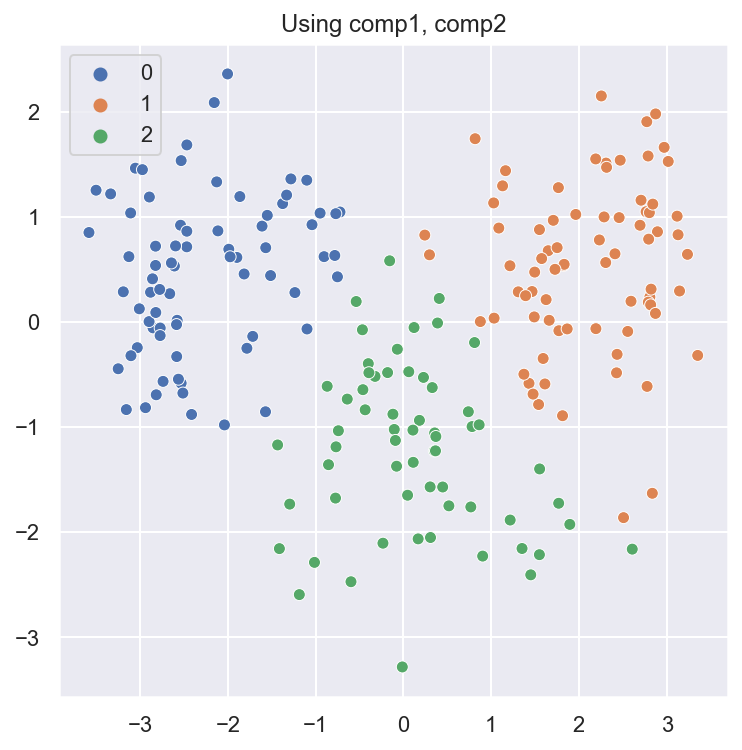

In [22]:
model2d.fit(plot='2d')